# Covid-19 und Feinstaubdatenanalyse

In der folgenden Datenanalyse wurden die Covid19-Daten des RKI und die Feinstaubdaten des Bundesministeriums zur Analyse verwendet. Es wurde untersucht ob die Daten miteinander korrelieren.
Für die Datengewinnung und Datenbearbeitung wurde Pandas, numpy und scipy verwendet.
Für das ploten der Daten, wurde die Matplotlib verwendet.

- Gruppenmitglieder:
    * Anna Kuhn 
    * Benjamin Hamm
    * Michael Schulze
    * Jan Klotter

In [99]:
#Abhängigkeiten importieren

import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import numpy as np
from scipy.stats import pearsonr
import collections
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.dates as mdates

## 1. Datenaufbereitung 

Als ersten Schritt müssen die Daten aufbereitet werden. Die Corona-Daten von Mannheim liegen in mehreren Einträgen vor und müssen deshalb auf einen Tag aufsummiert werden. Fehlende Einträge werden auf 0 gesetzt.

In [6]:
#Daten aus Datei auslesen mithilfe von Pandas

covid_data_germany = pd.read_csv('RKI_COVID19.csv')
feinstaub_data_mannheim = pd.read_csv('Luftqualitaet.csv',sep=';')

Die folgende Zelle filtriert die Corona-Daten aus Mannheim heraus und lediglich alle Daten aus dem Jahr 2020.

In [47]:
#Corona Daten nach Landkreis Mannheim filtern
covid_data_mannheim = covid_data_germany[covid_data_germany['Landkreis'] == 'SK Mannheim' ]

#Corona Daten nach Datum sortieren
#sortedByDate_covid_data_mannheim = covid_data_mannheim.sort_values(by='Refdatum')

#2021 Werte aussortiert
covid_data_mannheim = covid_data_mannheim[
        covid_data_mannheim['Refdatum'] <= '2020/12/31 00:00:00' ]


Die Feinstaubdaten hatten viele Leerdaten, welche aussortiert werden mussten.

In [48]:
#Tage an denen nicht aufgenommen wurde aussortieren
feinstaub_data_mannheim = feinstaub_data_mannheim[feinstaub_data_mannheim['Feinstaub (PM₁₀) stündlich gleitendes Tagesmittel in µg/m³'] != '-']

#Umweltbundesamt Eintrag aussortieren
feinstaub_data_mannheim = feinstaub_data_mannheim[:-2]

Damit die Anzahl der Covid-19-Fälle mit den Feinstaubdaten verglichen werden kann, muss ein Tagesmittel für die Feinstaubdaten ausgerechnet werden. Die Covid-19-Fälle müssen auch gefiltert werden.
Dadurch kann man die Anzahl der Covid-19-Fällen gegenüber den Tagesmittel der Feinstaubdaten korrelieren lassen.

In [49]:
#Fallzahlen und Todeszahlen pro Tag bestimmen

neuinfektionen_nach_datum = {}
todesfaelle_nach_datum = {}

for key, value in enumerate(covid_data_mannheim['Refdatum']):
    if value[:10] not in neuinfektionen_nach_datum:
        todesfaelle_nach_datum[value[:10]] = [np.array(covid_data_mannheim['AnzahlTodesfall'])[key]]
        neuinfektionen_nach_datum[value[:10]] = [np.array(covid_data_mannheim['AnzahlFall'])[key]]
    else:
        todesfaelle_nach_datum[value[:10]].append(np.array(covid_data_mannheim['AnzahlTodesfall'])[key])
        neuinfektionen_nach_datum[value[:10]].append(np.array(covid_data_mannheim['AnzahlFall'])[key])
        
        wert = neuinfektionen_nach_datum[value[:10]]
        neuinfektionen_nach_datum[value[:10]] = [np.sum(np.array(wert))]
    
        wert = todesfaelle_nach_datum[value[:10]]
        todesfaelle_nach_datum[value[:10]] = [np.sum(np.array(wert))]

In [50]:
#Tagesmittel Feinstaub (PM₁₀) pro Tag bestimmen

feinstaub_data_mannheim_nach_datum = {}

for key, value in enumerate(feinstaub_data_mannheim['Datum']):
    if type(value) is float:
        break;
        
    new_date = str(datetime.strptime(value[:10],"%d.%m.%Y"))[:10]
    
    if new_date not in feinstaub_data_mannheim_nach_datum:
        
        feinstaub_data_mannheim_nach_datum[new_date] = [np.array(feinstaub_data_mannheim['Feinstaub (PM₁₀) stündlich gleitendes Tagesmittel in µg/m³'])[key]]
    else:
        
        feinstaub_data_mannheim_nach_datum[new_date].append(np.array(feinstaub_data_mannheim['Feinstaub (PM₁₀) stündlich gleitendes Tagesmittel in µg/m³'])[key])

Tage an denen keine Feinstaubdaten aufgenommen wurden, müssen 0 gesetzt werden. Sonst werden NaN-Werte korreliert.

In [51]:
#Tage an denen nicht aufgenommen wurde mit 0 auffüllen
for datum in feinstaub_data_mannheim_nach_datum.keys():
    
    if datum.replace("-", "/") not in neuinfektionen_nach_datum.keys():
        neuinfektionen_nach_datum[datum.replace("-", "/")] = [0]
        todesfaelle_nach_datum[datum.replace("-", "/")] = [0]
    
    feinstaub_data_mannheim_nach_datum[datum] = np.mean(np.array(feinstaub_data_mannheim_nach_datum[datum]))

Die Daten müssen nach passenden Datum sortiert werden, da sonst falsche Tagesdaten miteinander korreliert werden.

In [52]:
#Datum in richtiger Reihenfolge
sorted_neuinfektionen_nach_datum = collections.OrderedDict(sorted(neuinfektionen_nach_datum.items()))
sorted_todesfaelle_nach_datum = collections.OrderedDict(sorted(todesfaelle_nach_datum.items()))
sorted_feinstaub_data_mannheim_nach_datum = collections.OrderedDict(sorted(feinstaub_data_mannheim_nach_datum.items()))

anzahl_faelle_list = list(sorted_neuinfektionen_nach_datum.values())
anzahl_tode_list = list(sorted_todesfaelle_nach_datum.values())
feinstaub_list = list(sorted_feinstaub_data_mannheim_nach_datum.values())

## 2.Explorative Datenanalyse

Im folgenden Abschnitt werden die Daten geplotet.

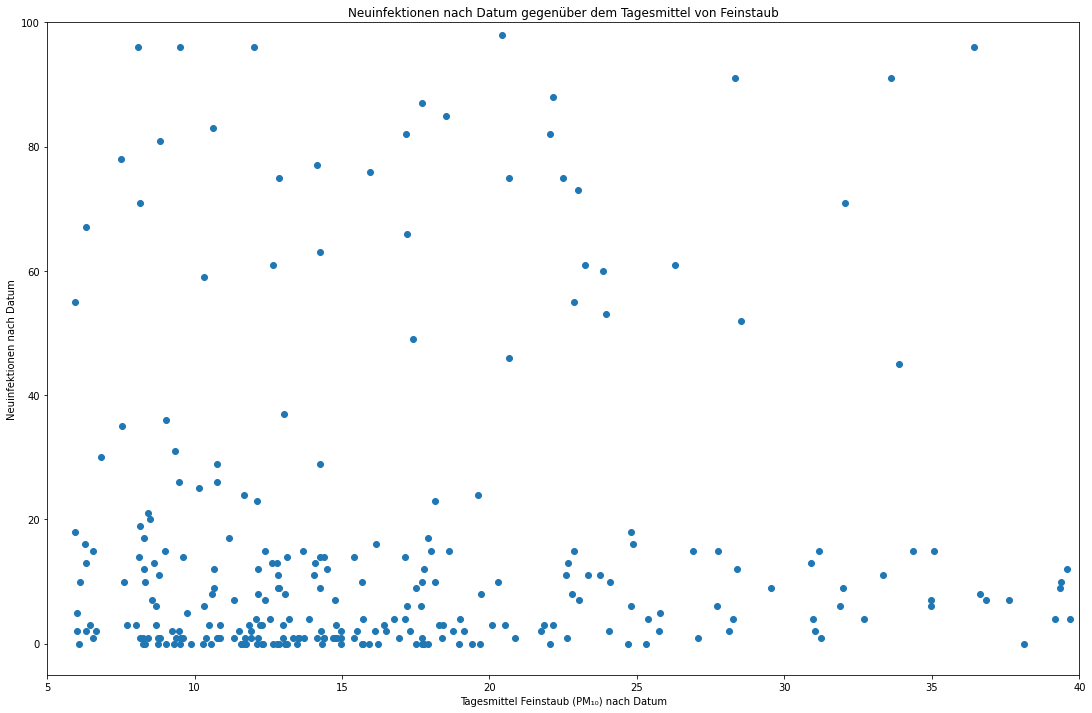

In [29]:

plt.scatter(feinstaub_list, anzahl_faelle_list)
fig = plt.gcf()
fig.set_size_inches(18.5,12)
plt.xlim([5,40])
plt.ylim([-5,100])
plt.title("Neuinfektionen nach Datum gegenüber dem Tagesmittel von Feinstaub")
plt.ylabel("Neuinfektionen nach Datum")
plt.xlabel("Tagesmittel Feinstaub (PM₁₀) nach Datum")
plt.show()

Aus dem Scatterplot kann man noch keinen linearen Zusammenhang zwischen den Daten erkennen.
Es sieht sehr gestreut aus.

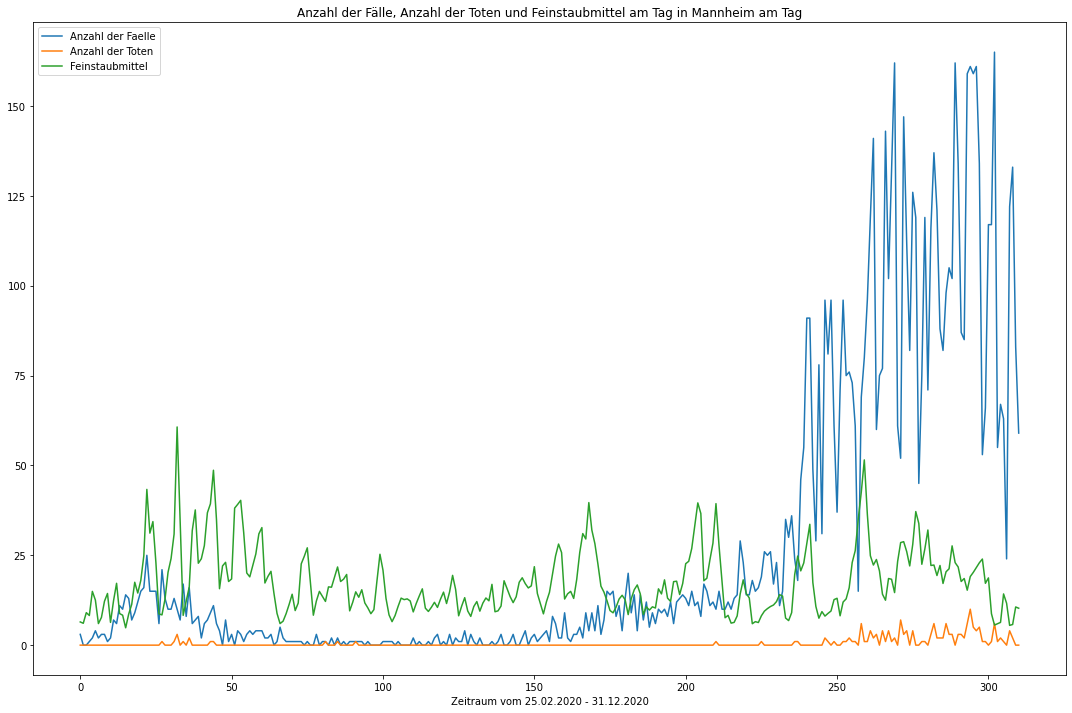

In [106]:
plt.plot(anzahl_faelle_list,label="Anzahl der Faelle")
plt.plot(anzahl_tode_list,label="Anzahl der Toten")
plt.plot(feinstaub_list,label="Feinstaubmittel")
fig = plt.gcf()
fig.set_size_inches(18.5,12)
plt.title("Anzahl der Fälle, Anzahl der Toten und Feinstaubmittel am Tag in Mannheim am Tag")
plt.xlabel("Zeitraum vom 25.02.2020 - 31.12.2020")
plt.legend()
plt.show()

Anhand der Daten erkennt man schon teilweise eine gewisse Korrelation. Sobald die Feinstaub-Daten sich erhöhen, erhöhen sich auch die Anzahl der Faelle.

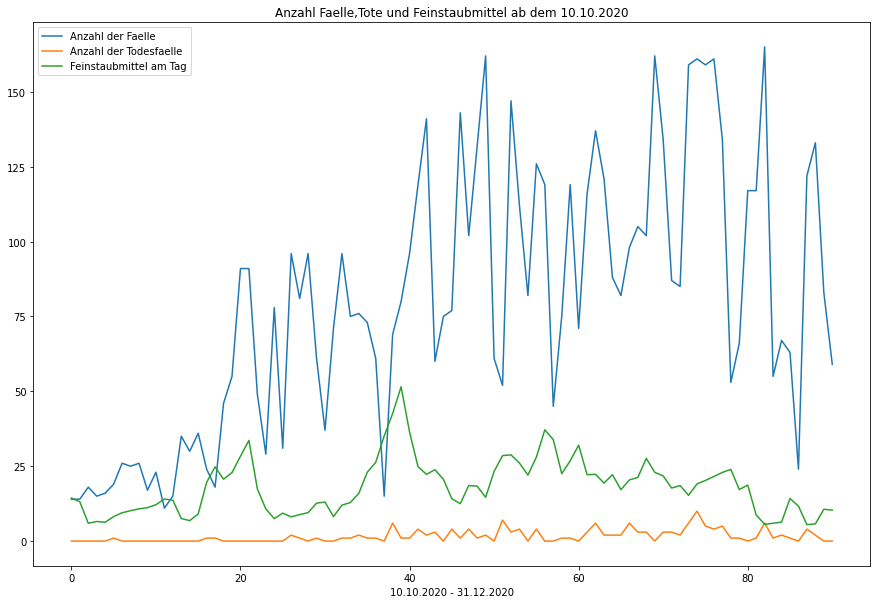

In [38]:
plt.plot(anzahl_faelle_list[220:],label="Anzahl der Faelle")
plt.plot(anzahl_tode_list[220:],label="Anzahl der Todesfaelle")
plt.plot(feinstaub_list[220:],label="Feinstaubmittel am Tag")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Anzahl Faelle,Tote und Feinstaubmittel ab dem 10.10.2020 in Mannheim am Tag")
plt.xlabel("10.10.2020 - 31.12.2020")
plt.legend()
plt.show()

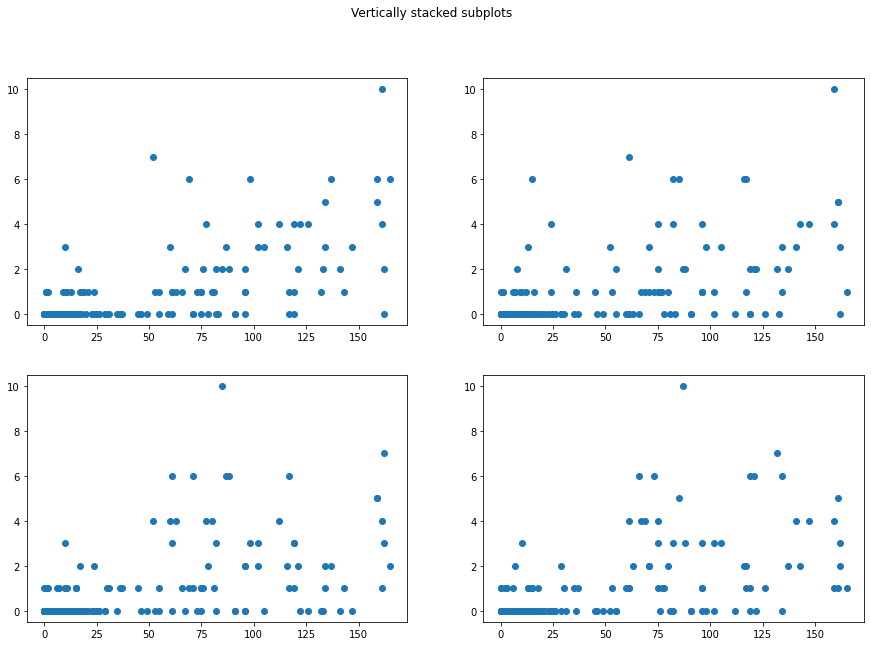

In [40]:
# Sollen wir die überhaupt drinnen behalten??? Man erkennt nichts :D
fig, axs = plt.subplots(2,2)
fig.suptitle('Vertically stacked subplots')
fig.set_size_inches(15,10)
axs[0,0].scatter(anzahl_faelle_list, anzahl_tode_list)
axs[0,1].scatter(anzahl_faelle_list[:-1], anzahl_tode_list[1:])
axs[1,0].scatter(anzahl_faelle_list[:-2], anzahl_tode_list[2:])
axs[1,1].scatter(anzahl_faelle_list[:-3], anzahl_tode_list[3:])
plt.show()

Im folgenden Plot wurde der Moving-Average der Anzahl der Todesfälle und die Anzahl der Corona-Fälle in Mannheim von 7 Tagen geplotet.

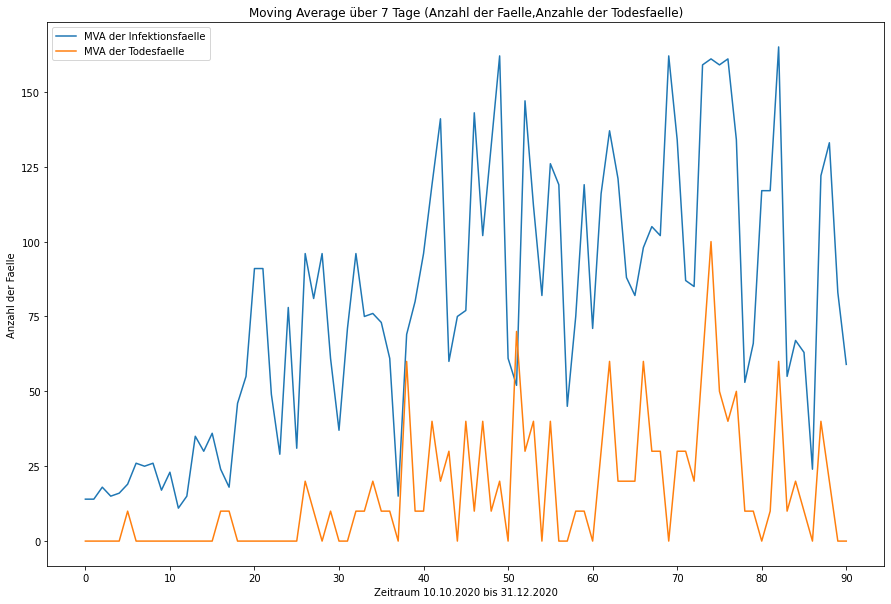

In [44]:
N = 7
anzahl_faelle_list_rm = uniform_filter1d(anzahl_faelle_list, size=N)
anzahl_tode_list_rm = uniform_filter1d(anzahl_tode_list, size=N)

plt.plot(anzahl_faelle_list_rm[220:],label="MVA der Infektionsfaelle")
plt.plot(anzahl_tode_list_rm[220:] * 10,label="MVA der Todesfaelle")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.legend()
plt.title("Moving Average über 7 Tage (Anzahl der Faelle,Anzahle der Todesfaelle) in Mannheim am Tag")
plt.xlabel("Zeitraum 10.10.2020 bis 31.12.2020")
plt.xticks(range(0,100,10))
plt.ylabel("Anzahl der Faelle")
plt.show()

Anhand der Abbildung erkennt man sehr gut, dass nach einem Peak der Infektionen, ein Paar Tage später die Infektionszahlen ansteigen.

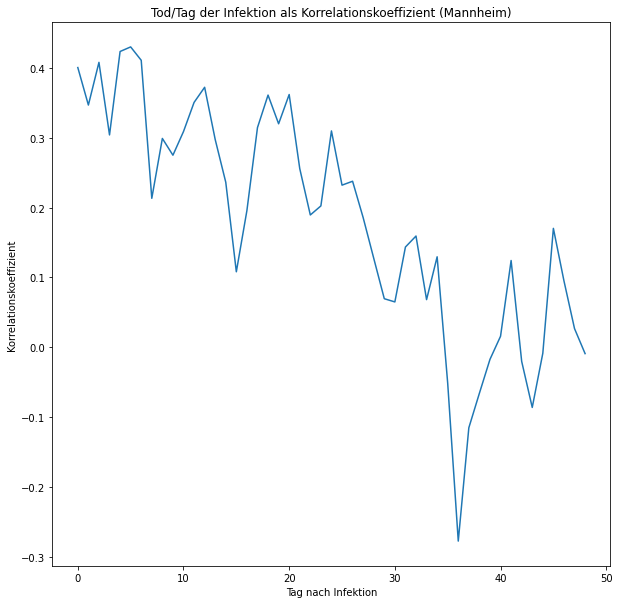

In [77]:
corrs = []
#anzahl_faelle_float = list(map(float, anzahl_faelle_list_rm ))
#anzahl_tode_float = list(map(float, anzahl_tode_list_rm )) 

anzahl_falle_float = [float(elem) for elem in anzahl_faelle_list_rm]
anzahl_tode_float = [float(elem) for elem in anzahl_tode_list_rm]

for i in range(1,50):
    corr,p= pearsonr(anzahl_faelle_float[220:-i], anzahl_tode_float[220+i:])
    corrs.append(corr)
    
plt.plot(corrs,label="Korrelationskoeffizient der Infektionsfaellen zu den Todesfaellen")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.xlabel("Tag nach Infektion")
plt.title("Tod/Tag der Infektion als Korrelationskoeffizient (Mannheim)")
plt.ylabel("Korrelationskoeffizient")
plt.show()

0.38 als Korrelationskoeffizient, in klinischen Studien ist das eine Korrelation.


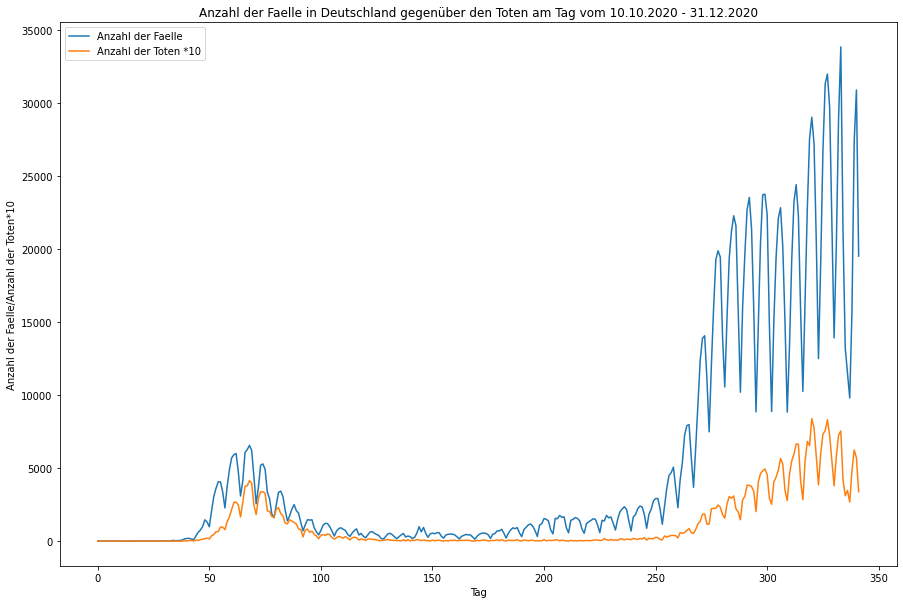

In [85]:
covid_data_germany = pd.read_csv('covid-19.csv',sep=';')

faelle_nach_datum = list(covid_data_germany['Faelle'])
todesfaelle_nach_datum = list(covid_data_germany['Todesfaelle']*10)

plt.plot(faelle_nach_datum,label="Anzahl der Faelle") 
plt.plot(todesfaelle_nach_datum,label="Anzahl der Toten *10")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.legend()
plt.title("Anzahl der Faelle in Deutschland gegenüber den Toten am Tag vom 10.10.2020 - 31.12.2020")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten*10")
plt.show()

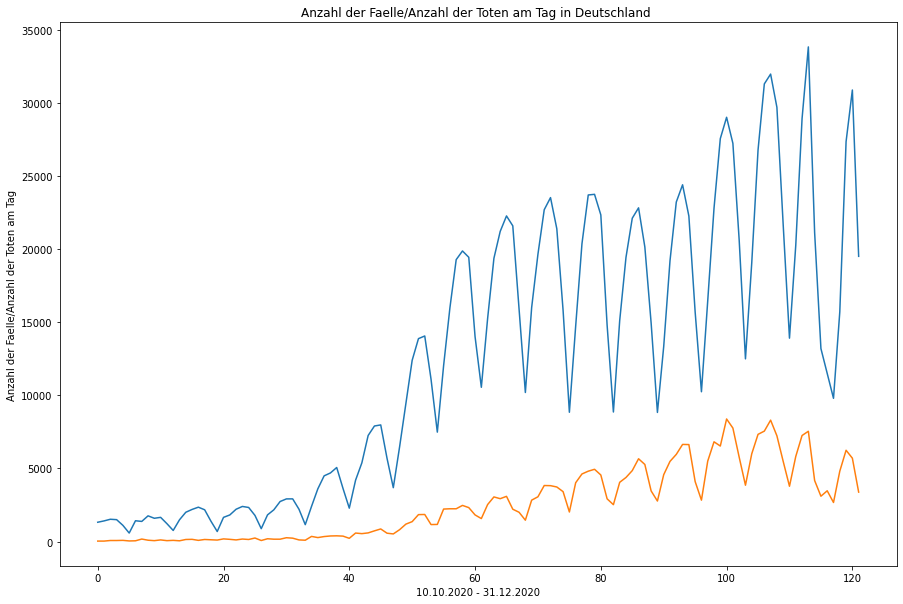

In [84]:
plt.plot(faelle_nach_datum[220:],label="Anzahl der Faelle")
plt.plot(todesfaelle_nach_datum[220:],label="Anzahl der Toten")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Anzahl der Faelle/Anzahl der Toten am Tag in Deutschland vom 10.10.2020 - 31.12.2020 ")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten am Tag")
plt.show()

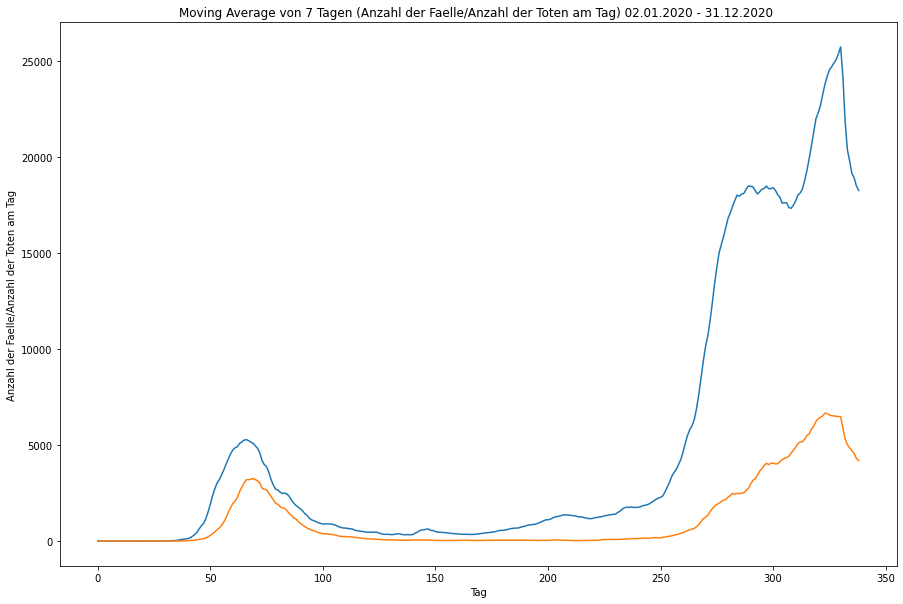

In [108]:
N = 7
anzahl_faelle_list_rm = uniform_filter1d(faelle_nach_datum, size=N)
anzahl_tode_list_rm = uniform_filter1d(todesfaelle_nach_datum, size=N)

plt.plot(anzahl_faelle_list_rm,label="Anzahl der Faelle")
plt.plot(anzahl_tode_list_rm,label="Anzahl der Tode")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Moving Average von 7 Tagen (Anzahl der Faelle/Anzahl der Toten am Tag) 02.01.2020 - 31.12.2020 ")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten am Tag")
plt.show()

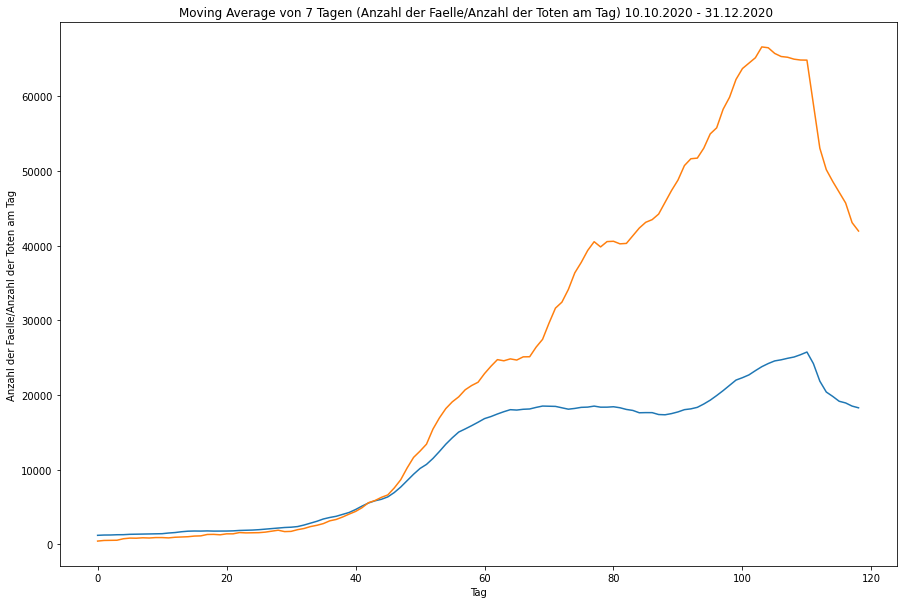

In [109]:
plt.plot(anzahl_faelle_list_rm[220:],label="Anzahl der Faelle")
plt.plot(anzahl_tode_list_rm[220:] * 10,label="Anzahl der Tode")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Moving Average von 7 Tagen (Anzahl der Faelle/Anzahl der Toten am Tag) 10.10.2020 - 31.12.2020 ")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten am Tag")
plt.show()

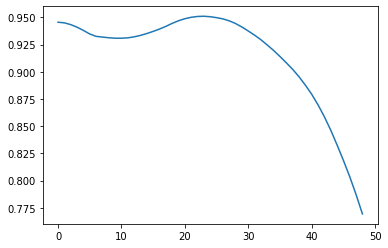

In [110]:
anzahl_faelle_list_rm = anzahl_faelle_list_rm[:-16]
anzahl_tode_list_rm = anzahl_tode_list_rm[:-16]
    
corrs = []
for i in range(1,50):
    corr,p= pearsonr(anzahl_faelle_list_rm[220:-i], anzahl_tode_list_rm[220+i:])
    corrs.append(corr)
    
plt.plot(corrs)
plt.show()